# Sensitivity of regression coefs to alternate choices
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import seaborn as sns
from rasterio import features
from affine import Affine
import geopandas as gp
import descartes
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from scipy import signal, stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

Data locations

In [2]:
loc_coefs = "../Data/RegressionResults/"
loc_panel = "../Data/Panel/"
loc_simulations = "../Data/DL_Test/"

#### Analysis

Read panel

In [3]:
y1 = 1960
y2 = 2019
panel = pd.read_csv(loc_panel+"ENSO_Growth_Panel_"+str(y1)+"-"+str(y2)+".csv",index_col=0)
panel_corrs = panel.t_p_corr_running_e.values

In [4]:
e = panel.loc[panel.iso=="USA","e"].values

In [5]:
p_corrs2_1 = panel.loc[panel.year.values==1960,"p_corr2_e"].values
p_corrs2 = np.unique(p_corrs2_1[~np.isnan(p_corrs2_1)])

print(len(p_corrs2))
print(len(p_corrs2[p_corrs2>0])/len(p_corrs2))
print(len(p_corrs2[p_corrs2<0])/len(p_corrs2))

156
0.6538461538461539
0.34615384615384615


Build massive figure and loop

0
Original model
-3.1127674886506895
1
Ni$\mathrm{\~n}$o3 index
-2.9016613235888573
2
World Bank growth data
-3.063710332836514
3
Including linear trends
-3.194256973187278
4
Including linear+quadratic trends
-2.9408405003192564
5
Excluding teleconnection > 0.8
-4.003862482539633
6
Including outliers
-3.4093855938230644
all
-3.1127674886506895
-7.218618580553598
wetting
-2.949867651776862
-6.87526472203356
drying
-3.3621031348668895
-7.696309557753539
[0.86915614 0.86750932 0.86518165 0.86164082 0.85560417 0.84299669
 0.80027844 1.28302193 0.93530555 0.90916272 0.89955242 0.89455958
 0.89150097 0.889435   0.88794591 0.88682168 0.88594284 0.88523696
 0.88465755 0.88417341 0.88376284 0.88341025 0.88310417 0.88283596
 0.88259901 0.88238815 0.8821993  0.88202918 0.88187514 0.88173499
 0.88160695 0.88148951 0.8813814  0.88128156 0.88118907 0.88110315
 0.88102311 0.88094839 0.88087846 0.88081288 0.88075126 0.88069324
 0.88063852 0.88058683 0.88053792 0.88049158 0.8804476 ]


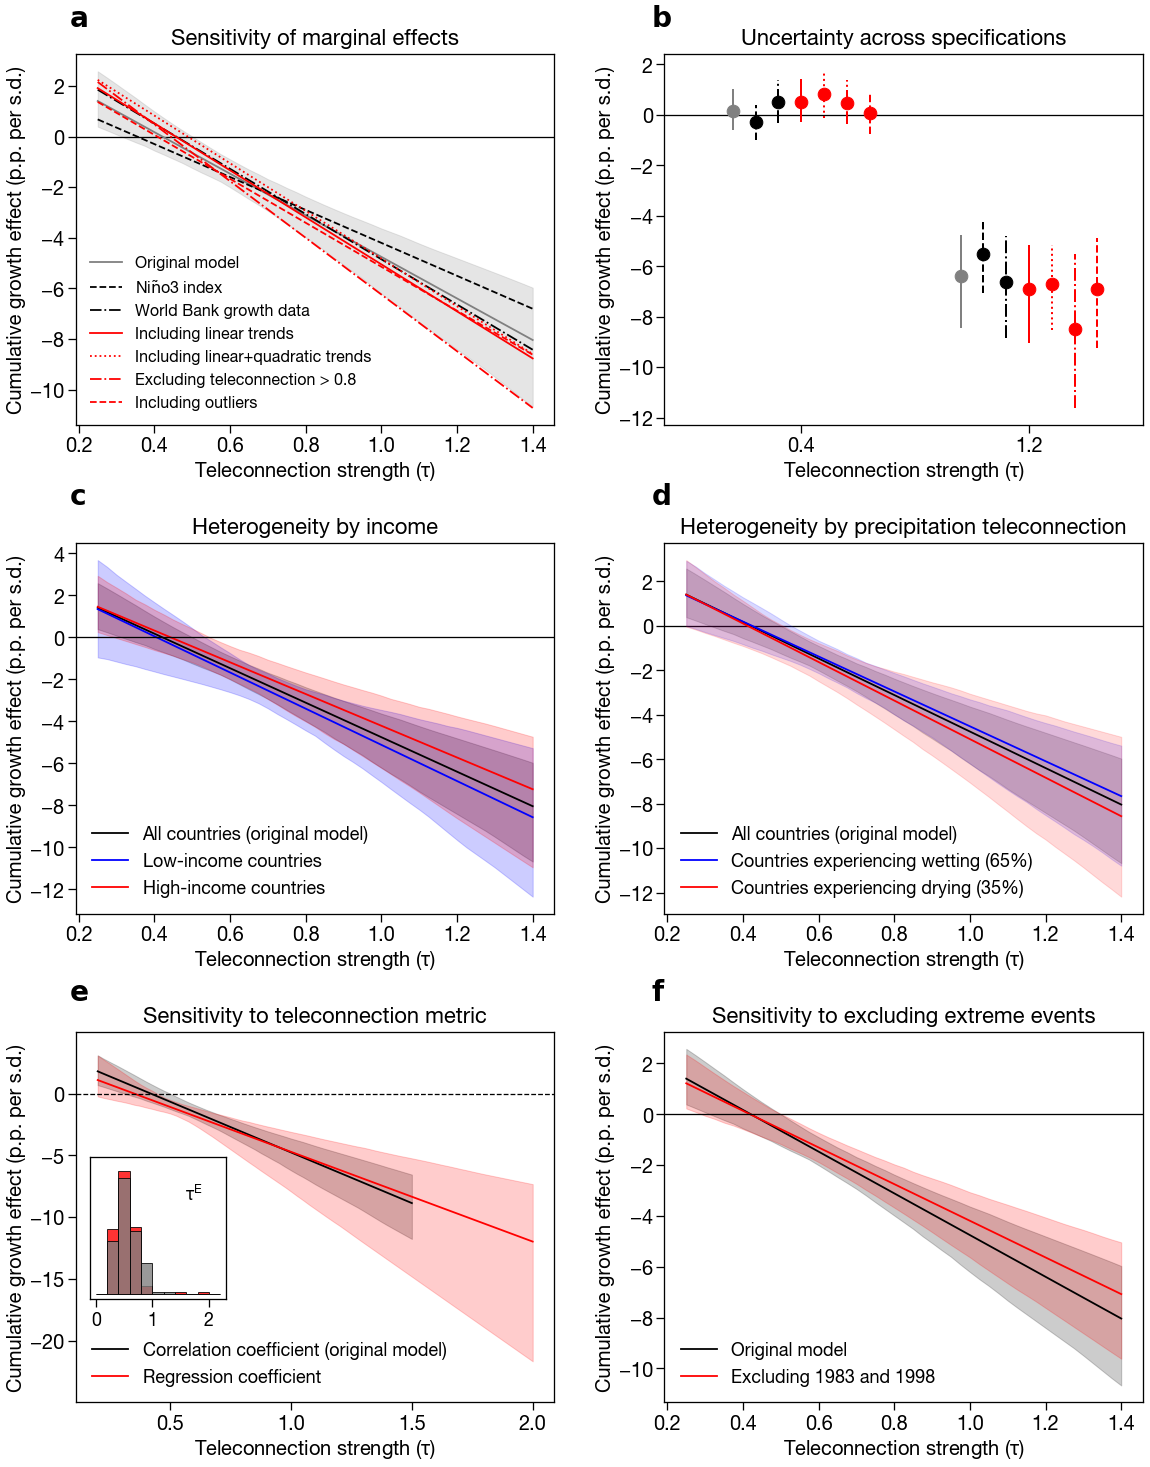

In [6]:
fig = plt.figure(figsize=(19,26))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"

gs1 = gridspec.GridSpec(3,2)
gs1.update(left=0.12,right=0.9,top=0.84,bottom=0.12,wspace=0.23,hspace=0.32)

tfs = 22

ax1 = plt.subplot(gs1[0,0])
plt.axhline(y=0,color="black",linewidth=1.3,linestyle="-",zorder=1)
plt.xlabel("Teleconnection strength ("+r"$\tau$)")
plt.ylabel("Cumulative growth effect (p.p. per s.d.)")
plt.title("Sensitivity of marginal effects",pad=10,fontsize=tfs)


ax2 = plt.subplot(gs1[0,1])
plt.xlabel("Teleconnection strength ("+r"$\tau$)")
plt.ylabel("Cumulative growth effect (p.p. per s.d.)")
plt.title("Uncertainty across specifications",pad=10,fontsize=tfs)
plt.axhline(y=0,color="black",linewidth=1.3,linestyle="-",zorder=1)
plt.xlim([-0.6,1.5])
plt.xticks(ticks=[0,1],labels=["0.4","1.2"])


#xvals_1 = [-0.4,-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4]
#xvals_2 = [0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4]
xvals_1 = [-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3]
xvals_2 = [0.7,0.8,0.9,1,1.1,1.2,1.3]

nlag = 5
n = 7
for j in np.arange(0,n,1):
    
    if j == 0:
        phase = "ENSO"
        enso_var = "e_e-and-c"
        response = "gr_pwt_frac"
        sens = ""
        trend = "none"
        col = "gray"
        style = "-"
        lab = "Original model"
    elif j == 1:
        phase = "ENSO"
        enso_var = "nino3"
        response = "gr_pwt_frac"
        sens = ""
        trend = "none"
        col = "black"
        style = "--"
        lab = "Ni"+r"$\mathrm{\~n}$o3 index"
    elif j == 2:
        phase = "ENSO"
        enso_var = "e_e-and-c"
        response = "growth_wb"
        sens = ""
        trend = "none"
        col = "black"
        style = "-."
        lab = "World Bank growth data"
    elif j == 3:
        phase = "ENSO"
        enso_var = "e_e-and-c"
        response = "gr_pwt_frac"
        sens = "trends"
        trend = "linear"
        col = "red"
        style = "-"
        lab = "Including linear trends"
    elif j == 4:
        phase = "ENSO"
        enso_var = "e_e-and-c"
        response = "gr_pwt_frac"
        sens = "trends2"
        trend = "linquad"
        col = "red"
        style = "dotted"
        lab = "Including linear+quadratic trends"
    elif j == 5:
        phase = "ENSO"
        enso_var = "e_e-and-c"
        response = "gr_pwt_frac"
        sens = "teleconnectionlimited"
        trend = "none"
        col = "red"
        style = "-."
        lab = "Excluding teleconnection > 0.8"
    elif j == 6:
        phase = "ENSO"
        enso_var = "e_e-and-c"
        response = "gr_pwt_frac"
        sens = "outliers"
        trend = "none"
        style = "--"
        lab = "Including outliers"
        
    # read in coefficients
    if len(sens)>0:
        enso_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interacted_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+"_sensitivity_"+sens+".csv",index_col=0)
        int_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interaction_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+"_sensitivity_"+sens+".csv",index_col=0)
    else:
        enso_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interacted_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+".csv",index_col=0)
        int_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interaction_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+".csv",index_col=0)
    nboot = len(int_coefs.coef_lag0.values)
    
    print(j)
    print(lab)
    print(100*(np.mean(np.sum(enso_coefs.iloc[:,1:].values,axis=1))+np.mean(np.sum(int_coefs.iloc[:,1:].values,axis=1))*0.8))
    
    # calculate marginal effects across correlations
    corrs = np.arange(0.25,1.4+0.01,0.025)
    
    corr_means = np.zeros((len(corrs),nlag+1))
    corr_upper = np.zeros((len(corrs),nlag+1))
    corr_lower = np.zeros((len(corrs),nlag+1))
    for c in corrs:
        corr_indiv = np.zeros((nboot,nlag+1))
        for l in np.arange(0,nlag+1,1):
            enso_coef = enso_coefs.loc[:,"coef_lag"+str(l)].values
            int_coef = int_coefs.loc[:,"coef_lag"+str(l)].values
            me = enso_coef + (int_coef * c)
            corr_indiv[:,l] = me
        
        cumulative = np.cumsum(corr_indiv,axis=1)
        corr_means[list(corrs).index(c),:] = np.mean(cumulative,axis=0)
        corr_upper[list(corrs).index(c),:] = np.percentile(cumulative,97.5,axis=0)
        corr_lower[list(corrs).index(c),:] = np.percentile(cumulative,2.5,axis=0)
    
    mn = corr_means[:,-1]*100
    upper = corr_upper[:,-1]*100
    lower = corr_lower[:,-1]*100
    ax1.plot(corrs,mn,color=col,linewidth=1.8,zorder=2,
            linestyle=style,label=lab)
    if (j == 0): #|(sens=="teleconnectionlimited"):
        ax1.fill_between(corrs,lower,upper,color="gray",
                        alpha=0.2,zorder=1)
        
    # now plot uncertainty on the second graph
    corr1 = 0.4
    corr2 = 1.2
    ind1 = list(np.around(corrs,3)).index(corr1)
    ind2 = list(np.around(corrs,3)).index(corr2)
    plt.scatter(xvals_1[j],mn[ind1],zorder=3,
               facecolor=col,s=160,edgecolor=col)
    plt.plot([xvals_1[j],xvals_1[j]],[lower[ind1],upper[ind1]],
            linewidth=2,zorder=2,linestyle=style,color=col)
    plt.scatter(xvals_2[j],mn[ind2],zorder=3,
               facecolor=col,s=160,edgecolor=col)
    plt.plot([xvals_2[j],xvals_2[j]],[lower[ind2],upper[ind2]],
            linewidth=2,zorder=2,linestyle=style,color=col)
    
    
ax1.legend(loc="lower left",fontsize=16,frameon=False,ncol=1)



## now high vs low income

groups = ["all","low","high"]
cols = ["black","blue","red"]

ax = plt.subplot(gs1[1,0])
plt.axhline(y=0,color="black",linewidth=1.3,linestyle="-")
plt.xlabel("Teleconnection strength ("+r"$\tau$)")
plt.ylabel("Cumulative growth effect (p.p. per s.d.)")
plt.title("Heterogeneity by income",fontsize=tfs,pad=10)

for j in np.arange(0,len(groups),1):
    group = groups[j]
    
    phase = "ENSO"
    enso_var = "e_e-and-c"
    response = "gr_pwt_frac"
    trend = "none"
    style = "-"
    if group=="low":
        lab = "Low-income countries"
    elif group=="high":
        lab = "High-income countries"
    elif group=="all":
        lab = "All countries (original model)"
    nlag = 5
        
    # read in coefficients
    if group!="all":
        enso_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interacted_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+"_"+group+"income.csv",index_col=0)
        int_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interaction_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+"_"+group+"income.csv",index_col=0)
    else:
        enso_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interacted_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+".csv",index_col=0)
        int_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interaction_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+".csv",index_col=0)
    nboot = len(int_coefs.coef_lag0.values)
    
    # calculate marginal effects across correlations
    corrs = np.arange(0.25,1.4+0.01,0.025)
    
    corr_means = np.zeros((len(corrs),nlag+1))
    corr_upper = np.zeros((len(corrs),nlag+1))
    corr_lower = np.zeros((len(corrs),nlag+1))
    for c in corrs:
        corr_indiv = np.zeros((nboot,nlag+1))
        for l in np.arange(0,nlag+1,1):
            enso_coef = enso_coefs.loc[:,"coef_lag"+str(l)].values
            int_coef = int_coefs.loc[:,"coef_lag"+str(l)].values
            me = enso_coef + (int_coef * c)
            corr_indiv[:,l] = me
        
        cumulative = np.cumsum(corr_indiv,axis=1)
        corr_means[list(corrs).index(c),:] = np.mean(cumulative,axis=0)
        corr_upper[list(corrs).index(c),:] = np.percentile(cumulative,97.5,axis=0)
        corr_lower[list(corrs).index(c),:] = np.percentile(cumulative,2.5,axis=0)
    
    lags = np.arange(0,nlag+1,1)
    mn = corr_means[:,-1]*100
    upper = corr_upper[:,-1]*100
    lower = corr_lower[:,-1]*100
    ax.plot(corrs,mn,color=cols[j],linewidth=1.8,zorder=1,
            linestyle=style,label=lab)
    ax.fill_between(corrs,lower,upper,color=cols[j],alpha=0.2,zorder=1)

ax.legend(loc="lower left",fontsize=18,frameon=False,ncol=1)    





ax = plt.subplot(gs1[1,1])

nlag = 5
trend = "none"
pct_wetting = int(100*np.around(len(p_corrs2[p_corrs2>0])/len(p_corrs2),2))
pct_drying = int(100*np.around(len(p_corrs2[p_corrs2<0])/len(p_corrs2),2))

for j in np.arange(0,3,1):
    
    if j == 1:
        phase = "ENSO"
        enso_var = "e_e-and-c"
        response = "gr_pwt_frac"
        sens = "positiveprecip"
        col = "blue"
        style = "-"
        lab = "Countries experiencing wetting ("+str(pct_wetting)+"%)"
        print("wetting")
    elif j == 2:
        phase = "ENSO"
        enso_var = "e_e-and-c"
        response = "gr_pwt_frac"
        sens = "negativeprecip"
        col = "red"
        style = "-"
        lab = "Countries experiencing drying ("+str(pct_drying)+"%)"
        print("drying")
    elif j == 0:
        phase = "ENSO"
        enso_var = "e_e-and-c"
        response = "gr_pwt_frac"
        sens = ""
        col = "black"
        style = "-"
        lab = "All countries (original model)"
        print("all")
        
    # read in coefficients
    if len(sens)>0:
        enso_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interacted_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+"_sensitivity_"+sens+".csv",index_col=0)
        int_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interaction_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+"_sensitivity_"+sens+".csv",index_col=0)
    else:
        enso_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interacted_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+".csv",index_col=0)
        int_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interaction_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+".csv",index_col=0)
    nboot = len(int_coefs.coef_lag0.values)
        
    print(100*(np.mean(np.sum(enso_coefs.iloc[:,1:].values,axis=1))+np.mean(np.sum(int_coefs.iloc[:,1:].values,axis=1))*0.8))
    print(100*(np.mean(np.sum(enso_coefs.iloc[:,1:].values,axis=1))+np.mean(np.sum(int_coefs.iloc[:,1:].values,axis=1))*1.3))
    
    # calculate marginal effects across correlations
    corrs = np.arange(0.25,1.4+0.01,0.025)
    
    corr_means = np.zeros((len(corrs),nlag+1))
    corr_upper = np.zeros((len(corrs),nlag+1))
    corr_lower = np.zeros((len(corrs),nlag+1))
    for c in corrs:
        corr_indiv = np.zeros((nboot,nlag+1))
        for l in np.arange(0,nlag+1,1):
            enso_coef = enso_coefs.loc[:,"coef_lag"+str(l)].values
            int_coef = int_coefs.loc[:,"coef_lag"+str(l)].values
            me = enso_coef + (int_coef * c)
            corr_indiv[:,l] = me
        
        cumulative = np.cumsum(corr_indiv,axis=1)
        corr_means[list(corrs).index(c),:] = np.mean(cumulative,axis=0)
        corr_upper[list(corrs).index(c),:] = np.percentile(cumulative,97.5,axis=0)
        corr_lower[list(corrs).index(c),:] = np.percentile(cumulative,2.5,axis=0)
    
    #mn = corr_means[:,1]*100
    #upper = corr_upper[:,1]*100
    #lower = corr_lower[:,1]*100
    #plt.plot(corrs,mn,color=col,linewidth=1.8,zorder=1,
    #        linestyle=style,label=lab)
    #ax.fill_between(corrs,lower,upper,color=col,
    #                    alpha=0.2,zorder=1)
    
    mn = corr_means[:,-1]*100
    upper = corr_upper[:,-1]*100
    lower = corr_lower[:,-1]*100
    plt.plot(corrs,mn,color=col,linewidth=1.8,zorder=3,
            linestyle=style,label=lab)
    ax.fill_between(corrs,lower,upper,color=col,
                        alpha=0.15,zorder=3)
    
plt.legend(loc="lower left",fontsize=18,frameon=False,ncol=1)
plt.axhline(y=0,color="black",linewidth=1.3,linestyle="-")
plt.xlabel("Teleconnection strength ("+r"$\tau$)")
plt.ylabel("Cumulative growth effect (p.p. per s.d.)")
plt.title("Heterogeneity by precipitation teleconnection",pad=10,fontsize=22)


## correlation vs regression coefficient

ax = plt.subplot(gs1[2,0])

cols = ["black","red"]
lbs = ["Correlation coefficient (original model)","Regression coefficient"]

for k in [0,1]:
    phase = "ENSO"
    enso_var = "e_e-and-c"
    response = "gr_pwt_frac"
    trend = "none"
    nlag = 5

    if k == 0:
        # original model
        enso_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interacted_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+".csv",index_col=0)
        int_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interaction_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+".csv",index_col=0)
        nboot = len(int_coefs.coef_lag0.values)
        corrs = np.arange(0.2,1.5+0.01,0.025)
    if k == 1:
        # reg coefficient
        enso_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interacted_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+"_teleconnections_regrunning.csv",index_col=0)
        int_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interaction_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+"_teleconnections_regrunning.csv",index_col=0)
        nboot = len(int_coefs.coef_lag0.values)
        corrs = np.arange(0.2,2+0.01,0.025)
        
    corr_means = np.zeros((len(corrs),nlag+1))
    corr_upper = np.zeros((len(corrs),nlag+1))
    corr_lower = np.zeros((len(corrs),nlag+1))
    for c in corrs:
        corr_indiv = np.zeros((nboot,nlag+1))
        for l in np.arange(0,nlag+1,1):
            enso_coef = enso_coefs.loc[:,"coef_lag"+str(l)].values
            int_coef = int_coefs.loc[:,"coef_lag"+str(l)].values
            me = enso_coef + (int_coef * c)
            corr_indiv[:,l] = me

        cumulative = np.cumsum(corr_indiv,axis=1)
        corr_means[list(corrs).index(c),:] = np.mean(cumulative,axis=0)
        corr_upper[list(corrs).index(c),:] = np.percentile(cumulative,97.5,axis=0)
        corr_lower[list(corrs).index(c),:] = np.percentile(cumulative,2.5,axis=0)

    style = "-"
    mn = corr_means[:,-1]*100
    upper = corr_upper[:,-1]*100
    lower = corr_lower[:,-1]*100
    plt.plot(corrs,mn,color=cols[k],linewidth=1.8,zorder=1,
                linestyle=style,label=lbs[k])
    ax.fill_between(corrs,lower,upper,color=cols[k],
                    alpha=0.2,zorder=1)

plt.xlabel("Teleconnection strength ("+r"$\tau$)")
plt.ylabel("Cumulative growth effect (p.p. per s.d.)")

plt.legend(loc="lower left",frameon=False,fontsize=18)
plt.title("Sensitivity to teleconnection metric",fontsize=tfs,pad=10)
plt.axhline(y=0,linewidth=1.3,color="black",linestyle="--")
#plt.xlim([0.17,1.53])
#plt.xticks(np.arange(0.2,1.4+0.2,0.2))
plt.ylim([-25,5])
plt.yticks([-20,-15,-10,-5,0])


## inset for hists
inset_ax = fig.add_axes([0.13,0.175,0.1,0.076])
bns = np.arange(0,2.4,0.2)
inset_ax.hist(np.unique(panel.t_p_reg_running_e.values),
              facecolor="red",edgecolor="black",alpha=0.8,bins=bns)
inset_ax.hist(np.unique(panel.t_p_corr_running_e.values),
              facecolor="gray",edgecolor="black",alpha=0.8,
             bins=bns)
inset_ax.text(0.7,0.7,r'$\tau^E$',
              fontsize=18,transform=inset_ax.transAxes)
inset_ax.set_xticks(ticks=[0,1,2])
inset_ax.set_yticks([])
inset_ax.set_xticklabels(labels=["0","1","2"],fontsize=18)
#inset_ax.set_xlabel(r'$\tau^E$',fontsize=18)
#inset_ax.set_ylabel("Frequency",fontsize=18)
inset_ax.set_ylim([-3,80])


## excluding extremes 

ax = plt.subplot(gs1[2,1])

nlag = 5
trend = "none"
n = 2
for j in np.arange(0,n,1):
    
    if j == 0:
        phase = "ENSO"
        enso_var = "e_e-and-c"
        response = "gr_pwt_frac"
        sens = ""
        col = "black"
        style = "-"
        lab = "Original model"
        trend = "none"
    elif j == 1:
        phase = "ENSO"
        enso_var = "e_e-and-c"
        response = "gr_pwt_frac"
        sens = "noextreme"
        col = "red"
        style = "-"
        lab = "Excluding 1983 and 1998"
        trend = "none"
        
    # read in coefficients
    if len(sens)>0:
        enso_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interacted_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+"_sensitivity_"+sens+".csv",index_col=0)
        int_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interaction_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+"_sensitivity_"+sens+".csv",index_col=0)
    else:
        enso_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interacted_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+".csv",index_col=0)
        int_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interaction_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+".csv",index_col=0)
    nboot = len(int_coefs.coef_lag0.values)
    
    
    # calculate marginal effects across correlations
    corrs = np.arange(0.25,1.4+0.01,0.025)
    
    corr_means = np.zeros((len(corrs),nlag+1))
    corr_upper = np.zeros((len(corrs),nlag+1))
    corr_lower = np.zeros((len(corrs),nlag+1))
    for c in corrs:
        corr_indiv = np.zeros((nboot,nlag+1))
        for l in np.arange(0,nlag+1,1):
            enso_coef = enso_coefs.loc[:,"coef_lag"+str(l)].values
            int_coef = int_coefs.loc[:,"coef_lag"+str(l)].values
            me = enso_coef + (int_coef * c)
            corr_indiv[:,l] = me
        
        cumulative = np.cumsum(corr_indiv,axis=1)
        corr_means[list(corrs).index(c),:] = np.mean(cumulative,axis=0)
        corr_upper[list(corrs).index(c),:] = np.percentile(cumulative,97.5,axis=0)
        corr_lower[list(corrs).index(c),:] = np.percentile(cumulative,2.5,axis=0)
    
    mn = corr_means[:,-1]*100
    if len(sens)>0:
        mn_without_events = mn
    else:
        mn_with_events = mn
    upper = corr_upper[:,-1]*100
    lower = corr_lower[:,-1]*100
    plt.plot(corrs,mn,color=col,linewidth=1.8,zorder=1,
            linestyle=style,label=lab)
    ax.fill_between(corrs,lower,upper,color=col,
                        alpha=0.2,zorder=1)

print(mn_without_events/mn_with_events)
    
plt.legend(loc="lower left",fontsize=18,frameon=False,ncol=1)
plt.axhline(y=0,color="black",linewidth=1.3,linestyle="-")
plt.xlabel("Teleconnection strength ("+r"$\tau$)")
plt.ylabel("Cumulative growth effect (p.p. per s.d.)")
plt.title("Sensitivity to excluding extreme events",pad=10,fontsize=tfs)


plt.figtext(0.115,0.855,r'$\bf{a}$',fontsize=28)
plt.figtext(0.54,0.855,r'$\bf{b}$',fontsize=28)
plt.figtext(0.115,0.6,r'$\bf{c}$',fontsize=28)
plt.figtext(0.54,0.6,r'$\bf{d}$',fontsize=28)
plt.figtext(0.115,0.335,r'$\bf{e}$',fontsize=28)
plt.figtext(0.54,0.335,r'$\bf{f}$',fontsize=28)


plt.savefig("../Figures/FigX_Sensitivity_Heterogeneity.pdf")
plt.show()

Temp and precip controls

[ 1.40366871  1.19837616  0.9930836   0.78779105  0.58249849  0.37720594
  0.17191338 -0.03337917 -0.23867172 -0.44396428 -0.64925683 -0.85454939
 -1.05984194 -1.2651345  -1.47042705 -1.67571961 -1.88101216 -2.08630472
 -2.29159727 -2.49688982 -2.70218238 -2.90747493 -3.11276749 -3.31806004
 -3.5233526  -3.72864515 -3.93393771 -4.13923026 -4.34452282 -4.54981537
 -4.75510793 -4.96040048 -5.16569303 -5.37098559 -5.57627814 -5.7815707
 -5.98686325 -6.19215581 -6.39744836 -6.60274092 -6.80803347 -7.01332603
 -7.21861858 -7.42391114 -7.62920369 -7.83449624 -8.0397888 ]
[ 1.42476737  1.21201932  0.99927127  0.78652322  0.57377517  0.36102712
  0.14827907 -0.06446898 -0.27721703 -0.48996508 -0.70271313 -0.91546118
 -1.12820923 -1.34095728 -1.55370533 -1.76645338 -1.97920143 -2.19194948
 -2.40469753 -2.61744558 -2.83019363 -3.04294168 -3.25568973 -3.46843778
 -3.68118583 -3.89393388 -4.10668193 -4.31942997 -4.53217802 -4.74492607
 -4.95767412 -5.17042217 -5.38317022 -5.59591827 -5.80866632 -6

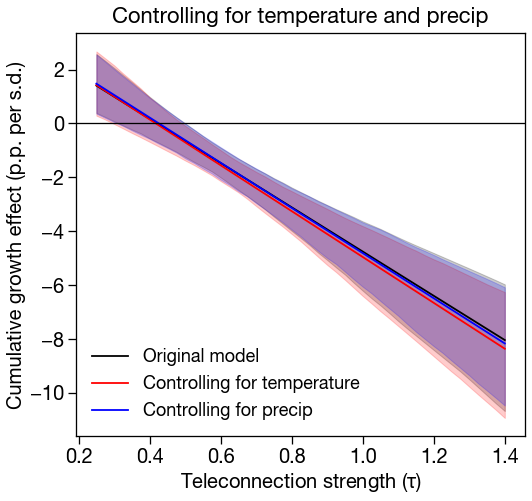

In [8]:
fig = plt.figure(figsize=(8,8))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"

gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.14,right=0.92,top=0.85,bottom=0.15,wspace=0.23,hspace=0.32)

tfs = 22

ax = plt.subplot(gs1[0,0])

nlag = 5
trend = "none"
n = 3
for j in np.arange(0,n,1):

    if j == 0:
        phase = "ENSO"
        enso_var = "e_e-and-c"
        response = "gr_pwt_frac"
        sens = ""
        col = "black"
        style = "-"
        lab = "Original model"
        trend = "none"
    elif j == 1:
        phase = "ENSO"
        enso_var = "e_e-and-c"
        response = "gr_pwt_frac"
        sens = "tempcontrol"
        col = "red"
        style = "-"
        lab = "Controlling for temperature"
        trend = "none"
    elif j == 2:
        phase = "ENSO"
        enso_var = "e_e-and-c"
        response = "gr_pwt_frac"
        sens = "precipcontrol"
        col = "blue"
        style = "-"
        lab = "Controlling for precip"
        trend = "none"

    # read in coefficients
    if len(sens)>0:
        enso_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interacted_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+"_sensitivity_"+sens+".csv",index_col=0)
        int_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interaction_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+"_sensitivity_"+sens+".csv",index_col=0)
    else:
        enso_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interacted_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+".csv",index_col=0)
        int_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interaction_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+".csv",index_col=0)
    nboot = len(int_coefs.coef_lag0.values)


    # calculate marginal effects across correlations
    corrs = np.arange(0.25,1.4+0.01,0.025)

    corr_means = np.zeros((len(corrs),nlag+1))
    corr_upper = np.zeros((len(corrs),nlag+1))
    corr_lower = np.zeros((len(corrs),nlag+1))
    for c in corrs:
        corr_indiv = np.zeros((nboot,nlag+1))
        for l in np.arange(0,nlag+1,1):
            enso_coef = enso_coefs.loc[:,"coef_lag"+str(l)].values
            int_coef = int_coefs.loc[:,"coef_lag"+str(l)].values
            me = enso_coef + (int_coef * c)
            corr_indiv[:,l] = me

        cumulative = np.cumsum(corr_indiv,axis=1)
        corr_means[list(corrs).index(c),:] = np.mean(cumulative,axis=0)
        corr_upper[list(corrs).index(c),:] = np.percentile(cumulative,97.5,axis=0)
        corr_lower[list(corrs).index(c),:] = np.percentile(cumulative,2.5,axis=0)

    mn = corr_means[:,-1]*100
    upper = corr_upper[:,-1]*100
    lower = corr_lower[:,-1]*100
    plt.plot(corrs,mn,color=col,linewidth=1.8,zorder=1,
                linestyle=style,label=lab)
    ax.fill_between(corrs,lower,upper,color=col,
                            alpha=0.2,zorder=1)
    print(mn)
plt.legend(loc="lower left",fontsize=18,frameon=False,ncol=1)
plt.axhline(y=0,color="black",linewidth=1.3,linestyle="-")
plt.xlabel("Teleconnection strength ("+r"$\tau$)")
plt.ylabel("Cumulative growth effect (p.p. per s.d.)")
plt.title("Controlling for temperature and precip",pad=10,fontsize=tfs)

plt.savefig("../Figures/FigX_TempPrecip_Control.pdf")

plt.show()

Plot more than 5 lags

10
[-0.87021457 -1.47716863 -2.53471314 -3.44874548 -4.21076155 -4.86253102
 -5.28903335 -5.31569171 -5.14228592 -4.96761447 -5.04109408]
12
[-0.86795307 -1.42496354 -2.51964371 -3.40811902 -4.03735092 -4.7524723
 -5.42266497 -5.47066644 -5.27043184 -4.99573366 -4.96354059 -4.49221875
 -3.76544012]
13
[-0.8676724  -1.40544965 -2.5087685  -3.41780581 -3.98159767 -4.5879788
 -5.20763987 -5.48948383 -5.34236148 -5.10419196 -5.09746935 -4.54097756
 -3.70011687 -3.05410886]
14
[-0.62296988 -0.88531783 -1.46618064 -1.88653481 -2.07031391 -2.2075231
 -2.77415261 -2.9889385  -3.12718214 -2.79503827 -2.45764098 -1.71035758
 -0.21785337  0.68779002  1.66802993]


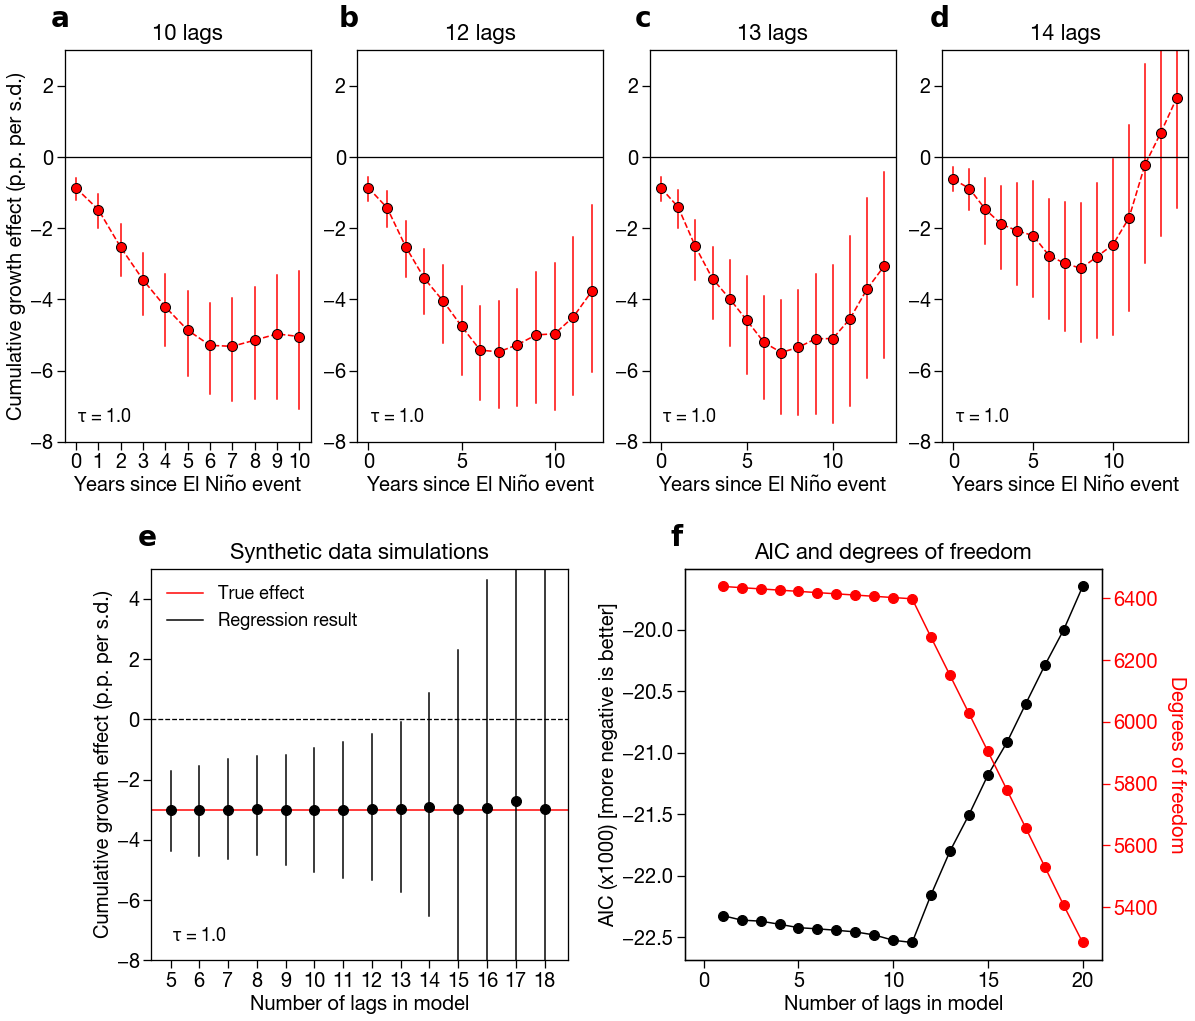

In [9]:
fig = plt.figure(figsize=(20,16))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"

gs1 = gridspec.GridSpec(1,4)
gs1.update(left=0.12,right=0.9,top=0.9,bottom=0.56,wspace=0.19,hspace=0.28)

tfs = 22

n_lag_list = [10,12,13,14]
for j in [0,1,2,3]:
    ax = plt.subplot(gs1[j])
    
    nlag = n_lag_list[j]
    
    phase = "ENSO"
    enso_var = "e_e-and-c"
    response = "gr_pwt_frac"
    trend = "none"
    # read in coefficients
    enso_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interacted_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+".csv",index_col=0)
    int_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interaction_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+".csv",index_col=0)
    nboot = len(int_coefs.coef_lag0.values)
    
    # calculate marginal effects
    corrs = np.arange(0.45,1.5+0.01,0.025)
    corr_means = np.zeros((len(corrs),nlag+1))
    corr_upper = np.zeros((len(corrs),nlag+1))
    corr_lower = np.zeros((len(corrs),nlag+1))
    for c in corrs:
        corr_indiv = np.zeros((nboot,nlag+1))
        for l in np.arange(0,nlag+1,1):
            enso_coef = enso_coefs.loc[:,"coef_lag"+str(l)].values
            int_coef = int_coefs.loc[:,"coef_lag"+str(l)].values
            me = enso_coef + (int_coef * c)
            corr_indiv[:,l] = me

        cumulative = np.cumsum(corr_indiv,axis=1)
        corr_means[list(corrs).index(c),:] = np.mean(cumulative,axis=0)
        corr_upper[list(corrs).index(c),:] = np.percentile(cumulative,97.5,axis=0)
        corr_lower[list(corrs).index(c),:] = np.percentile(cumulative,2.5,axis=0)
    
    corrs_plot = [1.0]
    bds_min = [0.95] #[0,0.6,0.8]
    bds_max = [1.05] #[0.6,0.8,1.4]
    ns = np.zeros(len(bds_min))
    mns = np.zeros(len(bds_min))
    for b in np.arange(0,len(bds_min),1):
        panel_corrs_uq = np.unique(panel_corrs)
        corrs_for_n = panel_corrs_uq[(~np.isnan(panel_corrs_uq))&(panel_corrs_uq>0.0)]
        ns[b] = int(len(corrs_for_n[[(x>=bds_min[b])&(x<bds_max[b]) for x in corrs_for_n]]))
        mns[b] = np.mean(corrs_for_n[[(x>=bds_min[b])&(x<bds_max[b]) for x in corrs_for_n]])

    for b in np.arange(0,len(bds_min),1):
        mn_corr = bds_min[b]
        mx_corr = bds_max[b]
        #lb = lbs[b]
        lags = np.arange(0,nlag+1,1)

        corr_inds = [(x>=mn_corr)&(x<mx_corr) for x in corrs]
        me_mean = np.mean(corr_means[corr_inds,:],axis=0)*100
        me_upper = np.mean(corr_upper[corr_inds,:],axis=0)*100
        me_lower = np.mean(corr_lower[corr_inds,:],axis=0)*100

        print(nlag)
        print(me_mean)
        plt.plot(lags,me_mean,color="red",markersize=10,
                    zorder=3,marker="o",linestyle="--",
                    linewidth=1.6,
                    markerfacecolor="red",markeredgecolor="black")
        for l in np.arange(0,nlag+1,1):
            plt.plot([l,l],[me_lower[l],me_upper[l]],
                        color="red",linewidth=1.5,linestyle="-",zorder=2)
    
    plt.title(str(nlag)+" lags",fontsize=tfs,pad=10)
    plt.axhline(y=0,color="black",linewidth=1.3,linestyle="-")
    plt.xlabel("Years since El Ni${\~n}$o event")
    if j==0:
        plt.ylabel("Cumulative growth effect (p.p. per s.d.)")
    plt.ylim([-8,3])
    if nlag==10:
        plt.xticks(np.arange(0,nlag+1,1))
    elif nlag==15:
        plt.xticks([0,5,10,15])
    elif nlag==20:
        plt.xticks([0,5,10,15,20])
    plt.text(0.05,0.05,r"$\tau$ = "+str(corrs_plot[0]),fontsize=18,transform=ax.transAxes)
        
# now simulation results from fake data and AIC values

gs2 = gridspec.GridSpec(1,2)
gs2.update(left=0.18,right=0.84,top=0.45,bottom=0.11,wspace=0.28,hspace=0.28)


ax = plt.subplot(gs2[0,0])

tau_test = 1.0

nlags = np.arange(5,18+1,1)
for l in np.arange(0,len(nlags),1):
    nlag = nlags[l]
    
    simulation_results = pd.read_csv(loc_simulations+"distributed_lag_test_laglength_"+str(nlag)+"_science_r1.csv",index_col=0)
    main_coef_e = simulation_results.main_coef_e.values
    int_coef_e = simulation_results.int_coef_e.values
    effect_e = 100*(main_coef_e + tau_test*int_coef_e)
    true_effect_e = 100*(simulation_results.true_main_coef_e.values[0] + tau_test*simulation_results.true_int_coef_e.values[0])
    #print(nlag)
    #print(np.mean(effect_e))
    #print(np.mean(true_effect_e))
    
    if l==0:
        plt.axhline(y=true_effect_e,color="red",linewidth=1.5,linestyle="-",
                   label="True effect",zorder=1)
    plt.scatter(nlag,np.mean(effect_e),s=100,color="black",zorder=2)

    upper = np.percentile(effect_e,97.5)
    lower = np.percentile(effect_e,2.5)
    #print(np.std(effect_e))
    
    if l == 0:
        plt.plot([nlag,nlag],[lower,upper],linewidth=1.5,color="black",zorder=3,
                label="Regression result")
    else:
        plt.plot([nlag,nlag],[lower,upper],linewidth=1.5,color="black",zorder=3)
    
plt.ylim([-8,5])
plt.ylabel("Cumulative growth effect (p.p. per s.d.)")
plt.axhline(y=0,color="black",linestyle="--",linewidth=1.3)
plt.xticks(nlags)
#plt.xlim([-0.5,2.5])
plt.xlabel("Number of lags in model")
#plt.ylabel("Density",labelpad=10)
#plt.xlim([-9,2.5])
#plt.yticks([])
plt.title("Synthetic data simulations",pad=10,fontsize=tfs)
plt.legend(loc="upper left",frameon=False,fontsize=18)
plt.text(0.05,0.05,r"$\tau$ = "+str(tau_test),fontsize=18,transform=ax.transAxes)


## now the AIC values to the right

ax = plt.subplot(gs2[0,1])
aic = pd.read_csv(loc_coefs+"ENSO_distributed_lag_e-and-c_AIC.csv",index_col=0)

plt.plot(aic.lags.values,aic.aic.values/1000,color="black",marker="o",
        markersize=10)
plt.xticks([0,5,10,15,20])
plt.xlim([-1,21])
plt.ylabel("AIC (x1000) [more negative is better]")
plt.xlabel("Number of lags in model")

plt.title("AIC and degrees of freedom",fontsize=tfs,pad=10)

ax2 = ax.twinx()
ax2.plot(aic.lags.values,aic.dof.values,color="red",marker="o",
        markersize=10)
#ax2.spines['right'].set_color('red')
ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='red')
ax2.set_ylabel("Degrees of freedom",rotation=270,labelpad=28)



# panels
plt.figtext(0.11,0.92,r'$\bf{a}$',fontsize=28)
plt.figtext(0.31,0.92,r'$\bf{b}$',fontsize=28)
plt.figtext(0.515,0.92,r'$\bf{c}$',fontsize=28)
plt.figtext(0.72,0.92,r'$\bf{d}$',fontsize=28)
plt.figtext(0.17,0.47,r'$\bf{e}$',fontsize=28)
plt.figtext(0.54,0.47,r'$\bf{f}$',fontsize=28)
#plt.figtext(0.535,0.48,r'$\bf{d}$',fontsize=28)


plt.savefig("../Figures/FigX_Additional_Lags.pdf")

plt.show()

C-index lags

10
[0.26255714 0.36456684 0.76394252 0.75295073 1.04704518 1.09468732
 1.21227038 1.0348932  1.01953711 0.99429956 0.96690716]
12
[0.43564113 0.54413461 0.74741332 0.73755201 1.09286357 1.24852558
 1.39479284 1.36636336 1.42984836 1.364473   0.99441742 1.04332469
 1.29047203]
13
[0.41984191 0.68105133 0.89948351 0.72173238 1.07578516 1.22516294
 1.44524033 1.38121106 1.55466842 1.53508811 1.16569037 1.00622054
 1.12623343 1.13452534]
14
[0.54963296 0.75933983 1.00479067 0.95652097 1.25155172 1.67368647
 1.93613502 2.28685943 2.31204537 2.52503365 2.12583116 1.83009469
 1.69699258 1.57543205 1.55626935]


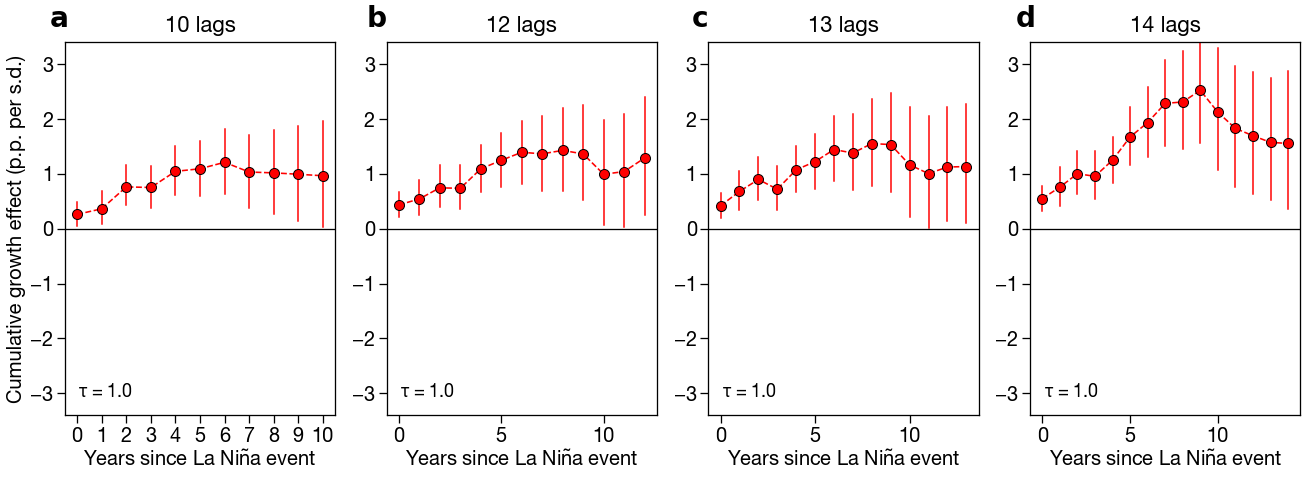

In [10]:
fig = plt.figure(figsize=(22,7))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"

gs1 = gridspec.GridSpec(1,4)
gs1.update(left=0.12,right=0.9,top=0.89,bottom=0.15,wspace=0.19,hspace=0.28)

tfs = 22

n_lag_list = [10,12,13,14]
for j in [0,1,2,3]:
    ax = plt.subplot(gs1[j])
    
    nlag = n_lag_list[j]
    
    phase = "ENSO"
    enso_var = "c_e-and-c"
    response = "gr_pwt_frac"
    trend = "none"
    # read in coefficients
    enso_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interacted_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+".csv",index_col=0)
    int_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interaction_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+".csv",index_col=0)
    nboot = len(int_coefs.coef_lag0.values)
    
    # calculate marginal effects
    corrs = np.arange(0.45,1.5+0.01,0.025)
    corr_means = np.zeros((len(corrs),nlag+1))
    corr_upper = np.zeros((len(corrs),nlag+1))
    corr_lower = np.zeros((len(corrs),nlag+1))
    for c in corrs:
        corr_indiv = np.zeros((nboot,nlag+1))
        for l in np.arange(0,nlag+1,1):
            enso_coef = enso_coefs.loc[:,"coef_lag"+str(l)].values
            int_coef = int_coefs.loc[:,"coef_lag"+str(l)].values
            me = enso_coef + (int_coef * c)
            corr_indiv[:,l] = me*-1

        cumulative = np.cumsum(corr_indiv,axis=1)
        corr_means[list(corrs).index(c),:] = np.mean(cumulative,axis=0)
        corr_upper[list(corrs).index(c),:] = np.percentile(cumulative,97.5,axis=0)
        corr_lower[list(corrs).index(c),:] = np.percentile(cumulative,2.5,axis=0)
    
    corrs_plot = [1.0]
    bds_min = [0.95] #[0,0.6,0.8]
    bds_max = [1.05] #[0.6,0.8,1.4]
    ns = np.zeros(len(bds_min))
    mns = np.zeros(len(bds_min))
    for b in np.arange(0,len(bds_min),1):
        panel_corrs_uq = np.unique(panel_corrs)
        corrs_for_n = panel_corrs_uq[(~np.isnan(panel_corrs_uq))&(panel_corrs_uq>0.0)]
        ns[b] = int(len(corrs_for_n[[(x>=bds_min[b])&(x<bds_max[b]) for x in corrs_for_n]]))
        mns[b] = np.mean(corrs_for_n[[(x>=bds_min[b])&(x<bds_max[b]) for x in corrs_for_n]])

    for b in np.arange(0,len(bds_min),1):
        mn_corr = bds_min[b]
        mx_corr = bds_max[b]
        #lb = lbs[b]
        lags = np.arange(0,nlag+1,1)

        corr_inds = [(x>=mn_corr)&(x<mx_corr) for x in corrs]
        me_mean = np.mean(corr_means[corr_inds,:],axis=0)*100
        me_upper = np.mean(corr_upper[corr_inds,:],axis=0)*100
        me_lower = np.mean(corr_lower[corr_inds,:],axis=0)*100

        print(nlag)
        print(me_mean)
        plt.plot(lags,me_mean,color="red",markersize=10,
                    zorder=3,marker="o",linestyle="--",
                    linewidth=1.6,
                    markerfacecolor="red",markeredgecolor="black")
        for l in np.arange(0,nlag+1,1):
            plt.plot([l,l],[me_lower[l],me_upper[l]],
                        color="red",linewidth=1.5,linestyle="-",zorder=2)
    
    plt.title(str(nlag)+" lags",fontsize=tfs,pad=10)
    plt.axhline(y=0,color="black",linewidth=1.3,linestyle="-")
    plt.xlabel("Years since La Ni${\~n}$a event")
    if j==0:
        plt.ylabel("Cumulative growth effect (p.p. per s.d.)")
    plt.ylim([-3.4,3.4])
    if nlag==10:
        plt.xticks(np.arange(0,nlag+1,1))
    elif nlag==15:
        plt.xticks([0,5,10,15])
    elif nlag==20:
        plt.xticks([0,5,10,15,20])
    plt.text(0.05,0.05,r"$\tau$ = "+str(corrs_plot[0]),fontsize=18,transform=ax.transAxes)


# panels
plt.figtext(0.11,0.92,r'$\bf{a}$',fontsize=28)
plt.figtext(0.31,0.92,r'$\bf{b}$',fontsize=28)
plt.figtext(0.515,0.92,r'$\bf{c}$',fontsize=28)
plt.figtext(0.72,0.92,r'$\bf{d}$',fontsize=28)

plt.savefig("../Figures/FigX_Additional_Lags_Cindex.pdf")
plt.show()

Different bootstrap types

In [11]:
boot_types = ["year","yr_reg","region","block"]
bt_names = ["year (globally)","year (within continents)","continent","five-year block"]

In [12]:
y1 = 1960
y2 = 2019
panel = pd.read_csv(loc_panel+"ENSO_Growth_Panel_"+str(y1)+"-"+str(y2)+".csv",index_col=0)
panel_corrs = panel.t_p_corr_running_e.values
corrs = np.arange(0.25,1.4+0.01,0.01)

In [13]:
nlag = 5
phase = "ENSO"
enso_var = "e_e-and-c"
response = "gr_pwt_frac"
trend = "none"

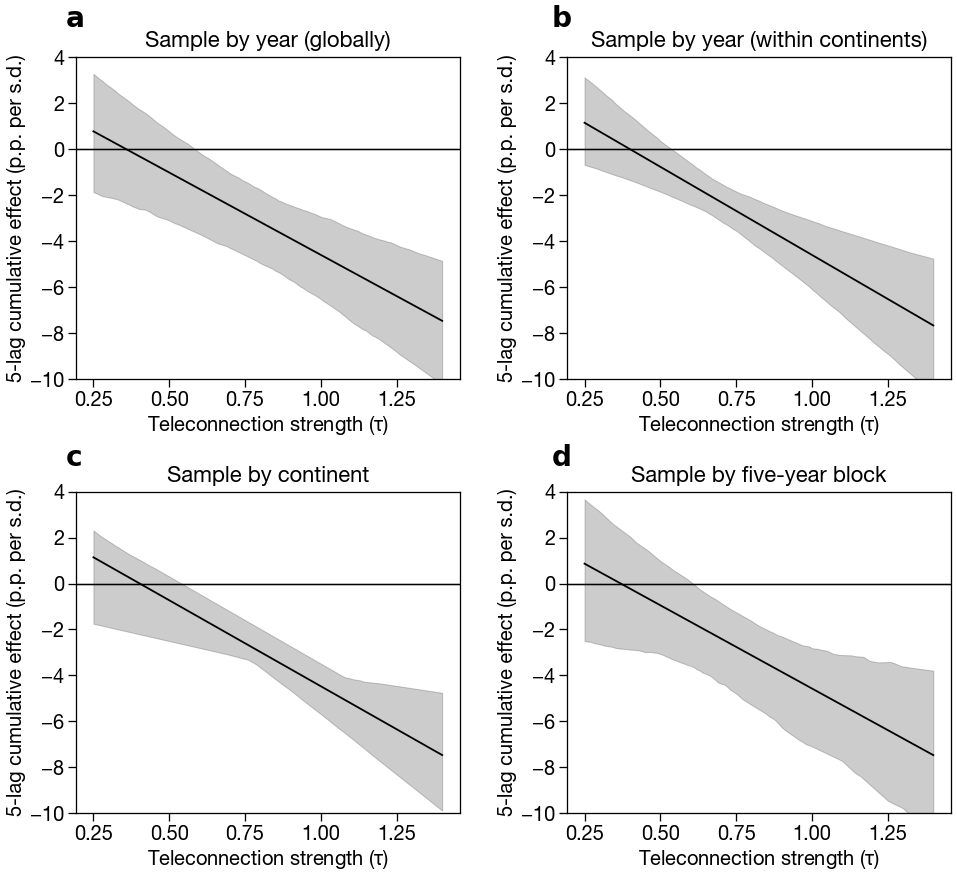

In [14]:
fig = plt.figure(figsize=(15,14))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"

gs2 = gridspec.GridSpec(2,2)
gs2.update(left=0.13,right=0.94,top=0.88,bottom=0.13,wspace=0.28,hspace=0.35)

for b in np.arange(0,len(boot_types),1):
    bt = boot_types[b]
    ax = plt.subplot(gs2[b])

    tfs = 22
    
    # read in coefficients
    enso_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interacted_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+"_bootstrap_"+bt+".csv",index_col=0)
    int_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interaction_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+"_bootstrap_"+bt+".csv",index_col=0)
    nboot = len(int_coefs.coef_lag0.values)

    # calculate marginal effects
    corr_means = np.zeros((len(corrs),nlag+1))
    corr_upper = np.zeros((len(corrs),nlag+1))
    corr_lower = np.zeros((len(corrs),nlag+1))
    for c in corrs:
        corr_indiv = np.zeros((nboot,nlag+1))
        for l in np.arange(0,nlag+1,1):
            enso_coef = enso_coefs.loc[:,"coef_lag"+str(l)].values
            int_coef = int_coefs.loc[:,"coef_lag"+str(l)].values
            me = enso_coef + (int_coef * c)
            corr_indiv[:,l] = me

        cumulative = np.cumsum(corr_indiv,axis=1)
        corr_means[list(corrs).index(c),:] = np.mean(cumulative,axis=0)
        corr_upper[list(corrs).index(c),:] = np.percentile(cumulative,97.5,axis=0)
        corr_lower[list(corrs).index(c),:] = np.percentile(cumulative,2.5,axis=0)
    
    mn = corr_means[:,-1]*100
    upper = corr_upper[:,-1]*100
    lower = corr_lower[:,-1]*100
    plt.plot(corrs,mn,color="black",linewidth=1.8,zorder=1,
            linestyle="-")
    ax.fill_between(corrs,lower,upper,color="black",
                        alpha=0.2,zorder=1)
    
    plt.title("Sample by "+str(bt_names[b]),fontsize=tfs,pad=10)
    plt.axhline(y=0,linewidth=1.3,color="black",linestyle="-",zorder=1)
    #plt.xticks(np.arange(0,10+1,1))
    #plt.xlabel("Years since El Ni${\~n}$o event")
    #plt.title("10 lags",pad=10,fontsize=tfs)
    plt.ylim([-10,4])
    #plt.yticks([-4,-3,-2,-1,0])
    plt.axhline(y=0,color="black",linewidth=1.3,linestyle="-")
    plt.xlabel("Teleconnection strength ("+r"$\tau$)")
    plt.ylabel(str(nlag)+"-lag cumulative effect (p.p. per s.d.)")


plt.figtext(0.12,0.91,r'$\bf{a}$',fontsize=28)
plt.figtext(0.57,0.91,r'$\bf{b}$',fontsize=28)
plt.figtext(0.12,0.475,r'$\bf{c}$',fontsize=28)
plt.figtext(0.57,0.475,r'$\bf{d}$',fontsize=28)

plt.savefig("../Figures/FigX_Bootstrap_Clustering.pdf")
plt.show()

In [15]:
[np.nanmin(panel.t_p_corr_running_e.values),np.nanmax(panel.t_p_corr_running_e.values)]

[0.2852641025023439, 1.3782282224881373]

In [16]:
[np.nanmin(panel.p_corr_running_e.values),np.nanmax(panel.p_corr_running_e.values)]

[0.1186572757338408, 0.6199687725819987]

In [17]:
[np.nanmin(panel.t_corr_running_e.values),np.nanmax(panel.t_corr_running_e.values)]

[0.10079668690905323, 0.8483270005484904]

Alternative teleconnections -- top row T/P distributions and marginal effects, bottom row correlation between our metric and significant sums and marginal effects of significant sums

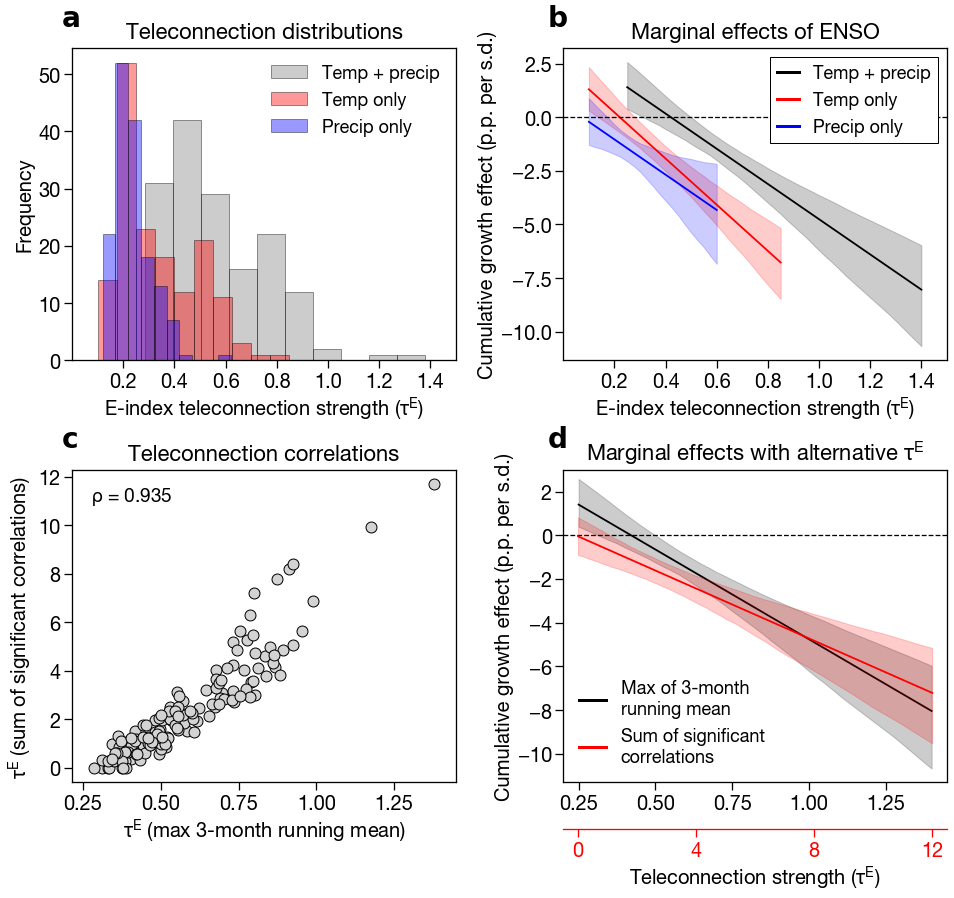

In [18]:
fig = plt.figure(figsize=(15,15))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"

gs2 = gridspec.GridSpec(2,2)
gs2.update(left=0.13,right=0.94,top=0.88,bottom=0.2,wspace=0.28,hspace=0.35)

ax = plt.subplot(gs2[0,0])

tp_corr = panel.loc[panel.year==1960,"t_p_corr_running_e"].values
tp_corr_plot = tp_corr[~np.isnan(tp_corr)]
plt.hist(tp_corr_plot,facecolor="gray",edgecolor="black",
        linewidth=1,alpha=0.4,label="Temp + precip")

t_corr = panel.loc[panel.year==1960,"t_corr_running_e"].values
t_corr_plot = t_corr[~np.isnan(t_corr)]
plt.hist(t_corr_plot,facecolor="red",edgecolor="black",
        linewidth=1,alpha=0.4,label="Temp only")

p_corr = panel.loc[panel.year==1960,"p_corr_running_e"].values
p_corr_plot = p_corr[~np.isnan(p_corr)]
plt.hist(p_corr_plot,facecolor="blue",edgecolor="black",
        linewidth=1,alpha=0.4,label="Precip only")


plt.xlim([0,1.5])
plt.xticks(np.arange(0.2,1.4+0.2,0.2))
plt.legend(loc="upper right",frameon=False,fontsize=18)
plt.xlabel("E-index teleconnection strength "+r"($\tau^E$)")
plt.ylabel("Frequency")
plt.title("Teleconnection distributions",pad=10,fontsize=tfs)


ax = plt.subplot(gs2[0,1])

cols = ["black","red","blue"]
lbs = ["Temp + precip","Temp only","Precip only"]
for k in [0,1,2]:
    phase = "ENSO"
    enso_var = "e_e-and-c"
    response = "gr_pwt_frac"
    trend = "none"
    nlag = 5

    if k == 0:
        # read in coefficients
        enso_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interacted_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+".csv",index_col=0)
        int_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interaction_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+".csv",index_col=0)
        nboot = len(int_coefs.coef_lag0.values)
        corrs = np.arange(0.25,1.4+0.01,0.025)
    if k == 1:
        # read in coefficients
        enso_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interacted_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+"_teleconnections_temponly.csv",index_col=0)
        int_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interaction_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+"_teleconnections_temponly.csv",index_col=0)
        nboot = len(int_coefs.coef_lag0.values)
        corrs = np.arange(0.1,0.85+0.01,0.025)
    if k == 2:
        # read in coefficients
        enso_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interacted_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+"_teleconnections_preciponly.csv",index_col=0)
        int_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interaction_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+"_teleconnections_preciponly.csv",index_col=0)
        nboot = len(int_coefs.coef_lag0.values)
        corrs = np.arange(0.1,0.6+0.01,0.025)
        
    corr_means = np.zeros((len(corrs),nlag+1))
    corr_upper = np.zeros((len(corrs),nlag+1))
    corr_lower = np.zeros((len(corrs),nlag+1))
    for c in corrs:
        corr_indiv = np.zeros((nboot,nlag+1))
        for l in np.arange(0,nlag+1,1):
            enso_coef = enso_coefs.loc[:,"coef_lag"+str(l)].values
            int_coef = int_coefs.loc[:,"coef_lag"+str(l)].values
            me = enso_coef + (int_coef * c)
            corr_indiv[:,l] = me

        cumulative = np.cumsum(corr_indiv,axis=1)
        corr_means[list(corrs).index(c),:] = np.mean(cumulative,axis=0)
        corr_upper[list(corrs).index(c),:] = np.percentile(cumulative,97.5,axis=0)
        corr_lower[list(corrs).index(c),:] = np.percentile(cumulative,2.5,axis=0)

    style = "-"
    mn = corr_means[:,-1]*100
    upper = corr_upper[:,-1]*100
    lower = corr_lower[:,-1]*100
    plt.plot(corrs,mn,color=cols[k],linewidth=1.8,zorder=1,
                linestyle=style,label=lbs[k])
    ax.fill_between(corrs,lower,upper,color=cols[k],
                    alpha=0.2,zorder=1)

    plt.xlabel("E-index teleconnection strength "+r"($\tau^E$)")
    plt.ylabel("Cumulative growth effect (p.p. per s.d.)")

leg = plt.legend(loc="upper right",frameon=True,fontsize=18,
          framealpha=1,fancybox=False,edgecolor=[0,0,0,1],
          handlelength=1.2)
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)
plt.title("Marginal effects of ENSO",fontsize=tfs,pad=10)
plt.axhline(y=0,linewidth=1.3,color="black",linestyle="--")
plt.xlim([0,1.5])
plt.xticks(np.arange(0.2,1.4+0.2,0.2))



## now correlation between teleconnections


ax = plt.subplot(gs2[1,0])

tc1 = panel.loc[panel.year==1960,"t_p_corr_running_e"]
tc2 = panel.loc[panel.year==1960,"t_p_corr_sum_sig_e"]

plt.scatter(tc1,tc2,s=120,facecolor="lightgray",edgecolor="black")

rhos = stats.spearmanr(tc1[(~np.isnan(tc1))&(~np.isnan(tc2))],tc2[(~np.isnan(tc1))&(~np.isnan(tc2))])
rho = np.around(rhos[0],3)

plt.text(0.05,0.9,r"$\rho$ = "+str(rho),fontsize=19,transform=ax.transAxes)
plt.xlabel(r"$\tau^E$ (max 3-month running mean)")
plt.ylabel(r"$\tau^E$ (sum of significant correlations)")

plt.title("Teleconnection correlations",fontsize=tfs,pad=10)


## marginal effects using the sum of significant correlations

ax = plt.subplot(gs2[1,1])

enso_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interacted_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+".csv",index_col=0)
int_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interaction_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+".csv",index_col=0)
nboot = len(int_coefs.coef_lag0.values)
corrs = np.arange(0.25,1.4+0.01,0.025)

corr_means = np.zeros((len(corrs),nlag+1))
corr_upper = np.zeros((len(corrs),nlag+1))
corr_lower = np.zeros((len(corrs),nlag+1))
for c in corrs:
    corr_indiv = np.zeros((nboot,nlag+1))
    for l in np.arange(0,nlag+1,1):
        enso_coef = enso_coefs.loc[:,"coef_lag"+str(l)].values
        int_coef = int_coefs.loc[:,"coef_lag"+str(l)].values
        me = enso_coef + (int_coef * c)
        corr_indiv[:,l] = me

    cumulative = np.cumsum(corr_indiv,axis=1)
    corr_means[list(corrs).index(c),:] = np.mean(cumulative,axis=0)
    corr_upper[list(corrs).index(c),:] = np.percentile(cumulative,97.5,axis=0)
    corr_lower[list(corrs).index(c),:] = np.percentile(cumulative,2.5,axis=0)

style = "-"
mn = corr_means[:,-1]*100
upper = corr_upper[:,-1]*100
lower = corr_lower[:,-1]*100
p1, = plt.plot(corrs,mn,color="black",linewidth=1.8,zorder=1,
                linestyle=style,label="Max of 3-month"+"\n"+"running mean")
ax.fill_between(corrs,lower,upper,color="black",
                    alpha=0.2,zorder=1)
ax.set_xlim([0.2,1.45])

plt.axhline(y=0,color="black",linestyle="--",linewidth=1.3)
plt.title("Marginal effects with alternative "+r"$\tau^E$",fontsize=tfs,pad=10)
#plt.xlabel(r"$\tau^E$ (sum of significant correlations)")

plt.ylabel("Cumulative growth effect (p.p. per s.d.)")


ax2 = ax.twiny()

enso_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interacted_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+"_teleconnections_sigsum.csv",index_col=0)
int_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interaction_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+"_teleconnections_sigsum.csv",index_col=0)
nboot = len(int_coefs.coef_lag0.values)
corrs = np.arange(0,12+0.05,0.05)

corr_means = np.zeros((len(corrs),nlag+1))
corr_upper = np.zeros((len(corrs),nlag+1))
corr_lower = np.zeros((len(corrs),nlag+1))
for c in corrs:
    corr_indiv = np.zeros((nboot,nlag+1))
    for l in np.arange(0,nlag+1,1):
        enso_coef = enso_coefs.loc[:,"coef_lag"+str(l)].values
        int_coef = int_coefs.loc[:,"coef_lag"+str(l)].values
        me = enso_coef + (int_coef * c)
        corr_indiv[:,l] = me

    cumulative = np.cumsum(corr_indiv,axis=1)
    corr_means[list(corrs).index(c),:] = np.mean(cumulative,axis=0)
    corr_upper[list(corrs).index(c),:] = np.percentile(cumulative,97.5,axis=0)
    corr_lower[list(corrs).index(c),:] = np.percentile(cumulative,2.5,axis=0)

style = "-"
mn = corr_means[:,-1]*100
upper = corr_upper[:,-1]*100
lower = corr_lower[:,-1]*100
p2, = ax2.plot(corrs,mn,color="red",linewidth=1.8,zorder=1,
                linestyle=style,label="Sum of significant"+"\n"+"correlations")
ax2.fill_between(corrs,lower,upper,color="red",
                    alpha=0.2,zorder=1)
ax2.spines["left"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
#ax2.spines["bottom"].set_visible(False)
ax2.spines["bottom"].set_position(("axes", -0.15))
ax2.spines["bottom"].set_edgecolor('red')

ax2.set_xlim([-0.5,12.5])
ax2.set_xticks([0,4,8,12])
ax2.tick_params(axis="x",colors="red")
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
ax2.set_xlabel("Teleconnection strength ("+r"$\tau^E$)")

lines = [p1, p2]
leg = ax2.legend(lines, [l.get_label() for l in lines],
          fontsize=18,loc="lower left",frameon=False,
                handlelength=1.5)
for line in leg.get_lines():
    line.set_linewidth(3.0)

ax2.set_yticks(np.arange(-10,2+2,2))
ax2.set_ylim([-11.3,3])

plt.figtext(0.12,0.9,r'$\bf{a}$',fontsize=28)
plt.figtext(0.57,0.9,r'$\bf{b}$',fontsize=28)
plt.figtext(0.12,0.51,r'$\bf{c}$',fontsize=28)
plt.figtext(0.57,0.51,r'$\bf{d}$',fontsize=28)

plt.savefig("../Figures/FigX_AltTeleconnections.pdf")
plt.show()